In [4]:
from transformers import Trainer,DataCollatorForTokenClassification, DistilBertForTokenClassification, \
                         DistilBertTokenizerFast,TrainingArguments, pipeline

from datasets import Dataset
import numpy as np
import evaluate

https://paperswithcode.com/dataset/snips 

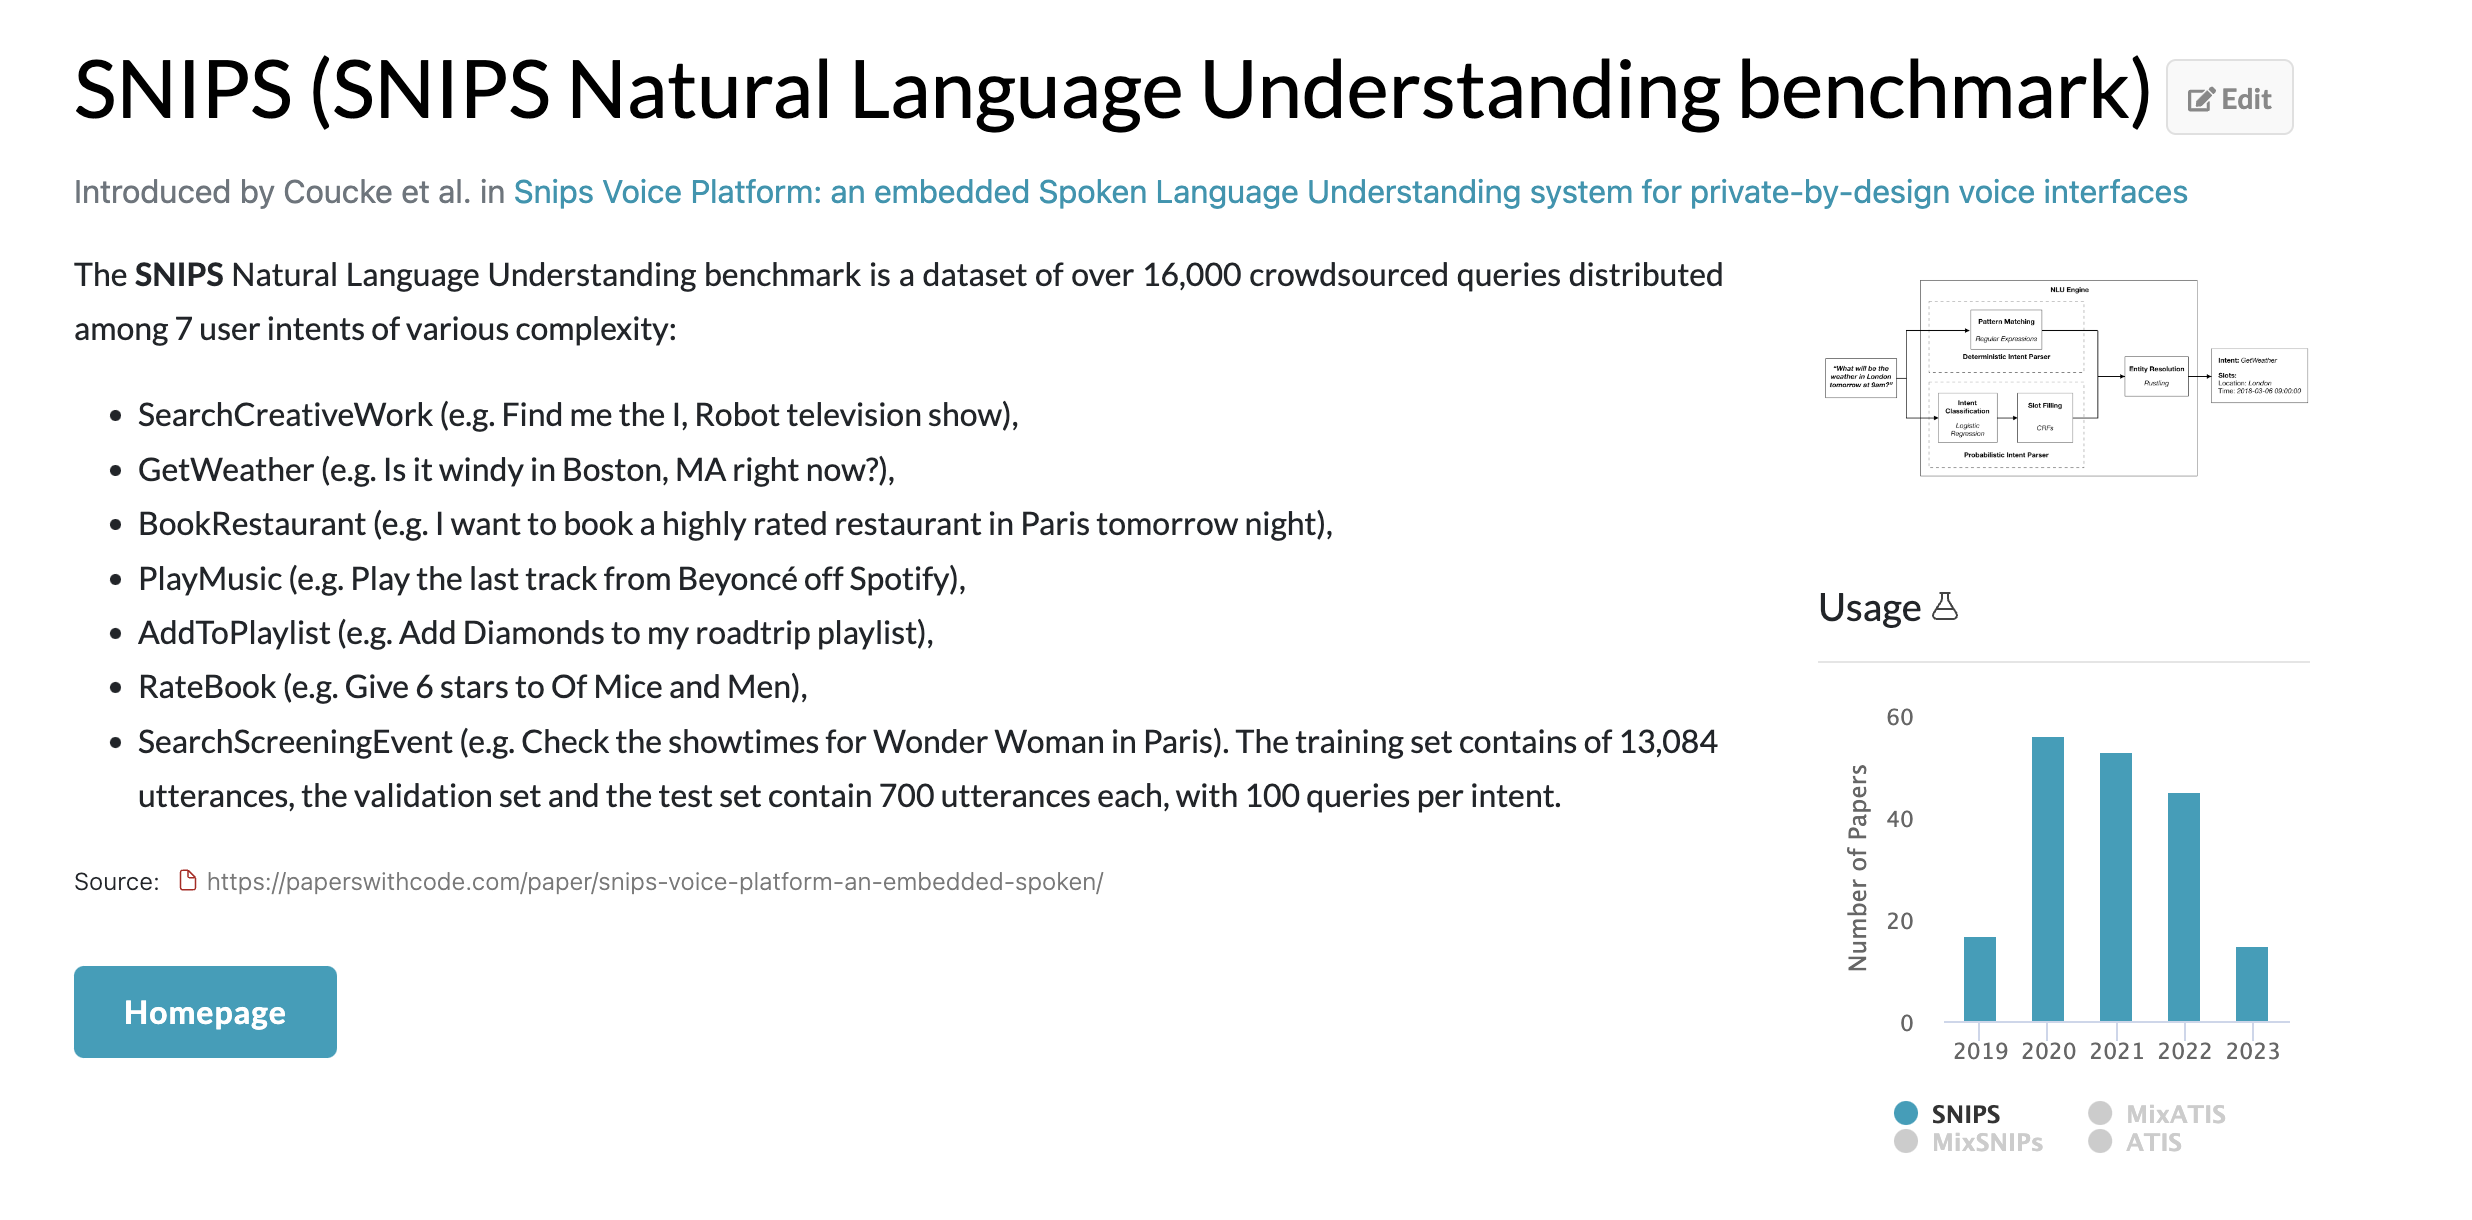

In [5]:
snips_file = open('../../Data/snips.train.txt', 'rb')
snips_rows = snips_file.readlines()

snips_rows[:20]

[b'listen O\r\n',
 b'to O\r\n',
 b'westbam B-artist\r\n',
 b'alumb O\r\n',
 b'allergic B-album\r\n',
 b'on O\r\n',
 b'google B-service\r\n',
 b'music I-service\r\n',
 b'PlayMusic\r\n',
 b'\r\n',
 b'add O\r\n',
 b'step B-entity_name\r\n',
 b'to I-entity_name\r\n',
 b'me I-entity_name\r\n',
 b'to O\r\n',
 b'the O\r\n',
 b'50 B-playlist\r\n',
 b'cl\xc3\xa1sicos I-playlist\r\n',
 b'playlist O\r\n',
 b'AddToPlaylist\r\n']

In [6]:
snips_rows[0]

b'listen O\r\n'

In [7]:
snips_rows[0].decode("utf-8").split()

['listen', 'O']

bu datadaki tokenler bertin token ı ile uygun olmayabilir. Haatırlarsanız bazı kelimeleri ikiye bölebiliyoru
bu fonksiyonun yaptığı şey kısaca bu.

In [8]:
# This code segment parses the snips dataset into a more manageable format

utterances = []
tokenized_utterances = []
labels_for_tokens = []
sequence_labels = []

utterance, tokenized_utterance, label_for_utterances = '', [], []
for snip_row in snips_rows:
    if len(snip_row) == 2:  # skip over rows with no data
        continue
    if ' ' not in snip_row.decode():  # we've hit a sequence label
        sequence_labels.append(snip_row.decode().strip())
        utterances.append(utterance.strip())
        tokenized_utterances.append(tokenized_utterance)
        labels_for_tokens.append(label_for_utterances)
        utterance = ''
        tokenized_utterance = []
        label_for_utterances = []
        continue
    token, token_label = snip_row.decode().split(' ')
    token_label = token_label.strip()
    utterance += f'{token} '
    tokenized_utterance.append(token)
    label_for_utterances.append(token_label)

In [9]:
len(labels_for_tokens), len(tokenized_utterances), len(utterances), len(sequence_labels)

(13084, 13084, 13084, 13084)

In [10]:
utterances[0], sequence_labels[0]

('listen to westbam alumb allergic on google music', 'PlayMusic')

In [11]:
from functools import reduce

unique_token_labels = list(set(reduce(lambda x, y: x + y, labels_for_tokens)))
labels_for_tokens = [[unique_token_labels.index(_) for _ in l] for l in labels_for_tokens]

print(f'There are {len(unique_token_labels)} unique token labels')

There are 72 unique token labels


In [12]:
unique_token_labels

['B-city',
 'I-object_type',
 'B-state',
 'B-object_select',
 'I-state',
 'I-entity_name',
 'I-artist',
 'B-party_size_description',
 'I-location_name',
 'B-poi',
 'B-facility',
 'B-geographic_poi',
 'I-music_item',
 'B-party_size_number',
 'I-party_size_description',
 'I-restaurant_name',
 'I-cuisine',
 'I-sort',
 'B-restaurant_type',
 'I-playlist_owner',
 'I-country',
 'I-spatial_relation',
 'I-facility',
 'B-playlist_owner',
 'I-geographic_poi',
 'B-object_type',
 'I-poi',
 'B-rating_value',
 'I-current_location',
 'B-object_part_of_series_type',
 'B-rating_unit',
 'B-location_name',
 'O',
 'I-object_location_type',
 'B-served_dish',
 'I-playlist',
 'B-movie_name',
 'B-entity_name',
 'I-movie_name',
 'B-movie_type',
 'B-object_name',
 'B-timeRange',
 'B-artist',
 'B-sort',
 'B-condition_temperature',
 'I-album',
 'I-served_dish',
 'B-music_item',
 'B-year',
 'B-genre',
 'I-city',
 'I-timeRange',
 'I-object_part_of_series_type',
 'B-cuisine',
 'B-condition_description',
 'B-object_lo

In [13]:
print(tokenized_utterances[0])
print(labels_for_tokens[0])
print([unique_token_labels[l] for l in labels_for_tokens[0]])
print(utterances[0])
print(sequence_labels[0])

['listen', 'to', 'westbam', 'alumb', 'allergic', 'on', 'google', 'music']
[32, 32, 42, 32, 68, 32, 57, 66]
['O', 'O', 'B-artist', 'O', 'B-album', 'O', 'B-service', 'I-service']
listen to westbam alumb allergic on google music
PlayMusic


In [14]:
snips_dataset = Dataset.from_dict(
    dict(
        utterance=utterances, 
        label=sequence_labels,
        tokens=tokenized_utterances,
        token_labels=labels_for_tokens
    )
)

snips_dataset = snips_dataset.train_test_split(test_size=0.2)

In [15]:
snips_dataset

DatasetDict({
    train: Dataset({
        features: ['utterance', 'label', 'tokens', 'token_labels'],
        num_rows: 10467
    })
    test: Dataset({
        features: ['utterance', 'label', 'tokens', 'token_labels'],
        num_rows: 2617
    })
})

In [91]:
snips_dataset['train'][0]

{'utterance': 'what is the weather in lloyd equatorial guinea',
 'label': 'GetWeather',
 'tokens': ['what',
  'is',
  'the',
  'weather',
  'in',
  'lloyd',
  'equatorial',
  'guinea'],
 'token_labels': [32, 32, 32, 32, 32, 0, 58, 20]}

In [17]:
# using a cased tokenizer because I think case will matter
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

/Users/kemalcankara/miniforge3/envs/nlpEnv/lib/python3.11/site-packages/huggingface_hub/utils/_hf_folder.py:92: UserWarning: A token has been found in `/Users/kemalcankara/.huggingface/token`. This is the old path where tokens were stored. The new location is `/Users/kemalcankara/.cache/huggingface/token` which is configurable using `HF_HOME` environment variable. Your token has been copied to this new location. You can now safely delete the old token file manually or use `huggingface-cli logout`.
  warnings.warn(


In [92]:
#ilk cümlenin token idlerinin bize veriyor
tokenized_inputs =tokenizer(snips_dataset['train'][0]['tokens'] , truncation=True, is_split_into_words=True)
tokenized_inputs

{'input_ids': [101, 1184, 1110, 1103, 4250, 1107, 1325, 7341, 1181, 174, 23416, 176, 14846, 4490, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [94]:
tokenizer.convert_ids_to_tokens([101, 1184, 1110, 1103, 4250, 1107, 1325, 7341, 1181, 174, 23416, 176, 14846, 4490, 102])

['[CLS]',
 'what',
 'is',
 'the',
 'weather',
 'in',
 'll',
 '##oy',
 '##d',
 'e',
 '##quatorial',
 'g',
 '##uin',
 '##ea',
 '[SEP]']

In [95]:
tokenized_inputs.word_ids(batch_index=0)#sep cls ler None, 

[None, 0, 1, 2, 3, 4, 5, 5, 5, 6, 6, 7, 7, 7, None]

In [21]:
# The given "token_labels" may not match up with the BERT wordpiece tokenization so
#  this function will map them to the tokenization that BERT uses
#  -100 is a reserved for labels where we do not want to calculate losses so BERT doesn't waste time
#  trying to predict tokens like CLS or SEP

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    #i 0,1,2... label ise her bir token için labelı tutacak
    for i, label in enumerate(examples[f"token_labels"]):
        #
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:  # Set the special tokens to -100.
                label_ids.append(-100)# reserved number in transfosmers ignore calculating loss for these tokens
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)  # CLS and SEP are labeled as -100
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [22]:
snips_dataset['train'][0]

{'utterance': 'what is the weather in lloyd equatorial guinea',
 'label': 'GetWeather',
 'tokens': ['what',
  'is',
  'the',
  'weather',
  'in',
  'lloyd',
  'equatorial',
  'guinea'],
 'token_labels': [32, 32, 32, 32, 32, 0, 58, 20]}

In [23]:
# map our dataset to be for token classification
tok_clf_tokenized_snips = snips_dataset.map(tokenize_and_align_labels, batched=True)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

In [24]:
tok_clf_tokenized_snips['train'][0]
#-100 ler için ilk kelimeyi işaretlememiz yetecek onu etiketled,iğimiz süerece tüm kelimeyi de yakayalabileceğiz tokenize olduğu şekliyle 

{'utterance': 'what is the weather in lloyd equatorial guinea',
 'label': 'GetWeather',
 'tokens': ['what',
  'is',
  'the',
  'weather',
  'in',
  'lloyd',
  'equatorial',
  'guinea'],
 'token_labels': [32, 32, 32, 32, 32, 0, 58, 20],
 'input_ids': [101,
  1184,
  1110,
  1103,
  4250,
  1107,
  1325,
  7341,
  1181,
  174,
  23416,
  176,
  14846,
  4490,
  102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100,
  32,
  32,
  32,
  32,
  32,
  0,
  -100,
  -100,
  58,
  -100,
  20,
  -100,
  -100,
  -100]}

In [25]:
tok_clf_tokenized_snips['train'] = tok_clf_tokenized_snips['train'].remove_columns(
    ['utterance', 'label', 'tokens', 'token_labels']
)
#label hugginface için reserved bir keyword olduğu için kaldırdık, sequence classification için kullanılır
tok_clf_tokenized_snips['test'] = tok_clf_tokenized_snips['test'].remove_columns(
    ['utterance', 'label', 'tokens', 'token_labels']
)

tok_clf_tokenized_snips

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 10467
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2617
    })
})

In [26]:
tok_data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [27]:
import wandb

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
tok_clf_model = DistilBertForTokenClassification.from_pretrained(
    'distilbert-base-cased', num_labels=len(unique_token_labels)
)

# Set our label dictionary
tok_clf_model.config.id2label = {i: l for i, l in enumerate(unique_token_labels)}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this 

In [29]:
tok_clf_model.config.id2label[0], tok_clf_model.config.id2label[1]

('B-city', 'I-object_type')

In [1]:
epochs = 2
j=0
training_args = TrainingArguments(
    output_dir="./snips_tok_clf/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    load_best_model_at_end=True,
        
    logging_steps=10,
    log_level='info',
    evaluation_strategy='epoch',
    save_strategy='epoch'
)

# Define the trainer:

trainer = Trainer(
    model=tok_clf_model,
    args=training_args,
    train_dataset=tok_clf_tokenized_snips['train'],
    eval_dataset=tok_clf_tokenized_snips['test'],
    data_collator=tok_data_collator
)

NameError: name 'TrainingArguments' is not defined

https://wandb.ai/kemalcankara/huggingface?workspace=user-kemalcankara 

In [31]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/82 [00:00<?, ?it/s]

Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: kemalcankara. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


{'eval_loss': 4.24664306640625,
 'eval_runtime': 36.4054,
 'eval_samples_per_second': 71.885,
 'eval_steps_per_second': 2.252}

In [32]:
trainer.train()## fine tune

/Users/kemalcankara/miniforge3/envs/nlpEnv/lib/python3.11/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10467
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 656
  Number of trainable parameters = 65246280


  0%|          | 0/656 [00:00<?, ?it/s]

{'loss': 3.3413, 'learning_rate': 4.923780487804878e-05, 'epoch': 0.03}
{'loss': 2.394, 'learning_rate': 4.847560975609756e-05, 'epoch': 0.06}
{'loss': 1.9474, 'learning_rate': 4.771341463414634e-05, 'epoch': 0.09}
{'loss': 1.5866, 'learning_rate': 4.695121951219512e-05, 'epoch': 0.12}
{'loss': 1.3315, 'learning_rate': 4.618902439024391e-05, 'epoch': 0.15}
{'loss': 1.0952, 'learning_rate': 4.542682926829269e-05, 'epoch': 0.18}
{'loss': 0.9437, 'learning_rate': 4.466463414634147e-05, 'epoch': 0.21}
{'loss': 0.8718, 'learning_rate': 4.390243902439025e-05, 'epoch': 0.24}
{'loss': 0.6722, 'learning_rate': 4.314024390243903e-05, 'epoch': 0.27}
{'loss': 0.6663, 'learning_rate': 4.237804878048781e-05, 'epoch': 0.3}
{'loss': 0.5617, 'learning_rate': 4.161585365853659e-05, 'epoch': 0.34}
{'loss': 0.5079, 'learning_rate': 4.085365853658537e-05, 'epoch': 0.37}
{'loss': 0.4719, 'learning_rate': 4.0091463414634153e-05, 'epoch': 0.4}
{'loss': 0.4394, 'learning_rate': 3.932926829268293e-05, 'epoch': 

***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


  0%|          | 0/82 [00:00<?, ?it/s]

Saving model checkpoint to ./snips_tok_clf/results/checkpoint-328
Configuration saved in ./snips_tok_clf/results/checkpoint-328/config.json


{'eval_loss': 0.1691083163022995, 'eval_runtime': 35.9408, 'eval_samples_per_second': 72.814, 'eval_steps_per_second': 2.282, 'epoch': 1.0}


Model weights saved in ./snips_tok_clf/results/checkpoint-328/pytorch_model.bin


{'loss': 0.201, 'learning_rate': 2.4847560975609756e-05, 'epoch': 1.01}
{'loss': 0.1434, 'learning_rate': 2.4085365853658536e-05, 'epoch': 1.04}
{'loss': 0.1651, 'learning_rate': 2.332317073170732e-05, 'epoch': 1.07}
{'loss': 0.1469, 'learning_rate': 2.25609756097561e-05, 'epoch': 1.1}
{'loss': 0.1826, 'learning_rate': 2.179878048780488e-05, 'epoch': 1.13}
{'loss': 0.157, 'learning_rate': 2.103658536585366e-05, 'epoch': 1.16}
{'loss': 0.1462, 'learning_rate': 2.0274390243902442e-05, 'epoch': 1.19}
{'loss': 0.1402, 'learning_rate': 1.9512195121951222e-05, 'epoch': 1.22}
{'loss': 0.13, 'learning_rate': 1.8750000000000002e-05, 'epoch': 1.25}
{'loss': 0.1291, 'learning_rate': 1.798780487804878e-05, 'epoch': 1.28}
{'loss': 0.1245, 'learning_rate': 1.722560975609756e-05, 'epoch': 1.31}
{'loss': 0.1239, 'learning_rate': 1.6463414634146345e-05, 'epoch': 1.34}
{'loss': 0.1447, 'learning_rate': 1.5701219512195124e-05, 'epoch': 1.37}
{'loss': 0.1506, 'learning_rate': 1.4939024390243902e-05, 'epoc

***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


  0%|          | 0/82 [00:00<?, ?it/s]

Saving model checkpoint to ./snips_tok_clf/results/checkpoint-656
Configuration saved in ./snips_tok_clf/results/checkpoint-656/config.json


{'eval_loss': 0.12414079904556274, 'eval_runtime': 36.7565, 'eval_samples_per_second': 71.198, 'eval_steps_per_second': 2.231, 'epoch': 2.0}


Model weights saved in ./snips_tok_clf/results/checkpoint-656/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./snips_tok_clf/results/checkpoint-656 (score: 0.12414079904556274).


{'train_runtime': 1016.5413, 'train_samples_per_second': 20.593, 'train_steps_per_second': 0.645, 'train_loss': 0.3951691705279234, 'epoch': 2.0}


TrainOutput(global_step=656, training_loss=0.3951691705279234, metrics={'train_runtime': 1016.5413, 'train_samples_per_second': 20.593, 'train_steps_per_second': 0.645, 'train_loss': 0.3951691705279234, 'epoch': 2.0})

In [33]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 2617
  Batch size = 32


  0%|          | 0/82 [00:00<?, ?it/s]

{'eval_loss': 0.12414079904556274,
 'eval_runtime': 38.391,
 'eval_samples_per_second': 68.167,
 'eval_steps_per_second': 2.136,
 'epoch': 2.0}

In [41]:
pipe = pipeline("token-classification", tok_clf_model, tokenizer=tokenizer)
pipe('Please add Here We Go by Dispatch to my road trip playlist')

[{'entity': 'B-entity_name',
  'score': 0.7947736,
  'index': 3,
  'word': 'Here',
  'start': 11,
  'end': 15},
 {'entity': 'I-entity_name',
  'score': 0.8587985,
  'index': 4,
  'word': 'We',
  'start': 16,
  'end': 18},
 {'entity': 'I-entity_name',
  'score': 0.8371516,
  'index': 5,
  'word': 'Go',
  'start': 19,
  'end': 21},
 {'entity': 'I-entity_name',
  'score': 0.75448644,
  'index': 6,
  'word': 'by',
  'start': 22,
  'end': 24},
 {'entity': 'B-artist',
  'score': 0.9128302,
  'index': 7,
  'word': 'Di',
  'start': 25,
  'end': 27},
 {'entity': 'I-artist',
  'score': 0.9368101,
  'index': 8,
  'word': '##sp',
  'start': 27,
  'end': 29},
 {'entity': 'I-artist',
  'score': 0.8827072,
  'index': 9,
  'word': '##atch',
  'start': 29,
  'end': 33},
 {'entity': 'B-playlist_owner',
  'score': 0.9948909,
  'index': 11,
  'word': 'my',
  'start': 37,
  'end': 39},
 {'entity': 'B-playlist',
  'score': 0.9943752,
  'index': 12,
  'word': 'road',
  'start': 40,
  'end': 44},
 {'entity': 

In [96]:
pipe = pipeline("token-classification", tok_clf_model, tokenizer=tokenizer)
pipe('Rate the dog food 5 out of 5')

[{'entity': 'B-object_name',
  'score': 0.968274,
  'index': 2,
  'word': 'the',
  'start': 5,
  'end': 8},
 {'entity': 'I-object_name',
  'score': 0.9789265,
  'index': 3,
  'word': 'dog',
  'start': 9,
  'end': 12},
 {'entity': 'I-object_name',
  'score': 0.9858101,
  'index': 4,
  'word': 'food',
  'start': 13,
  'end': 17},
 {'entity': 'B-rating_value',
  'score': 0.9955711,
  'index': 5,
  'word': '5',
  'start': 18,
  'end': 19},
 {'entity': 'B-best_rating',
  'score': 0.9593619,
  'index': 8,
  'word': '5',
  'start': 27,
  'end': 28}]

In [100]:
pipe = pipeline("token-classification", tok_clf_model, tokenizer=tokenizer)
print(pipe('Recep Tayyip Erdoğan is the new president of Turkey again!'))

[{'entity': 'I-artist', 'score': 0.49703813, 'index': 4, 'word': 'Ta', 'start': 6, 'end': 8}, {'entity': 'I-artist', 'score': 0.637886, 'index': 5, 'word': '##y', 'start': 8, 'end': 9}, {'entity': 'I-artist', 'score': 0.38188168, 'index': 6, 'word': '##yi', 'start': 9, 'end': 11}, {'entity': 'I-artist', 'score': 0.43440694, 'index': 7, 'word': '##p', 'start': 11, 'end': 12}, {'entity': 'I-artist', 'score': 0.84570444, 'index': 8, 'word': 'E', 'start': 13, 'end': 14}, {'entity': 'I-artist', 'score': 0.68800193, 'index': 9, 'word': '##rdo', 'start': 14, 'end': 17}, {'entity': 'I-artist', 'score': 0.6069539, 'index': 10, 'word': '##ğ', 'start': 17, 'end': 18}, {'entity': 'I-artist', 'score': 0.22938842, 'index': 11, 'word': '##an', 'start': 18, 'end': 20}, {'entity': 'I-object_name', 'score': 0.56360984, 'index': 14, 'word': 'new', 'start': 28, 'end': 31}, {'entity': 'I-object_name', 'score': 0.7454281, 'index': 15, 'word': 'president', 'start': 32, 'end': 41}, {'entity': 'I-object_name',

## Modeli kaydetmek ve Geri Çağırmak

In [37]:
pt_save_directory = "./pt_save_pretrained_ner"
tokenizer.save_pretrained(pt_save_directory)
tok_clf_model.save_pretrained(pt_save_directory)

tokenizer config file saved in ./pt_save_pretrained_ner/tokenizer_config.json
Special tokens file saved in ./pt_save_pretrained_ner/special_tokens_map.json
Configuration saved in ./pt_save_pretrained_ner/config.json
Model weights saved in ./pt_save_pretrained_ner/pytorch_model.bin


In [42]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

In [44]:
pt_model = AutoModelForTokenClassification.from_pretrained("./pt_save_pretrained_ner")
pt_tokenizer = AutoTokenizer.from_pretrained("./pt_save_pretrained_ner")
#predict


loading configuration file ./pt_save_pretrained_ner/config.json
Model config DistilBertConfig {
  "_name_or_path": "./pt_save_pretrained_ner",
  "activation": "gelu",
  "architectures": [
    "DistilBertForTokenClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "B-city",
    "1": "I-object_type",
    "2": "B-state",
    "3": "B-object_select",
    "4": "I-state",
    "5": "I-entity_name",
    "6": "I-artist",
    "7": "B-party_size_description",
    "8": "I-location_name",
    "9": "B-poi",
    "10": "B-facility",
    "11": "B-geographic_poi",
    "12": "I-music_item",
    "13": "B-party_size_number",
    "14": "I-party_size_description",
    "15": "I-restaurant_name",
    "16": "I-cuisine",
    "17": "I-sort",
    "18": "B-restaurant_type",
    "19": "I-playlist_owner",
    "20": "I-country",
    "21": "I-spatial_relation",
    "22": "I-facility",
    "23": "B-playlist_owner",
    "24": "I-geographic_poi",
  

In [45]:
pipe = pipeline("token-classification", pt_model, tokenizer=pt_tokenizer)
pipe('Please add Here We Go by Dispatch to my road trip playlist')

[{'entity': 'B-entity_name',
  'score': 0.7947736,
  'index': 3,
  'word': 'Here',
  'start': 11,
  'end': 15},
 {'entity': 'I-entity_name',
  'score': 0.8587985,
  'index': 4,
  'word': 'We',
  'start': 16,
  'end': 18},
 {'entity': 'I-entity_name',
  'score': 0.8371516,
  'index': 5,
  'word': 'Go',
  'start': 19,
  'end': 21},
 {'entity': 'I-entity_name',
  'score': 0.75448644,
  'index': 6,
  'word': 'by',
  'start': 22,
  'end': 24},
 {'entity': 'B-artist',
  'score': 0.9128302,
  'index': 7,
  'word': 'Di',
  'start': 25,
  'end': 27},
 {'entity': 'I-artist',
  'score': 0.9368101,
  'index': 8,
  'word': '##sp',
  'start': 27,
  'end': 29},
 {'entity': 'I-artist',
  'score': 0.8827072,
  'index': 9,
  'word': '##atch',
  'start': 29,
  'end': 33},
 {'entity': 'B-playlist_owner',
  'score': 0.9948909,
  'index': 11,
  'word': 'my',
  'start': 37,
  'end': 39},
 {'entity': 'B-playlist',
  'score': 0.9943752,
  'index': 12,
  'word': 'road',
  'start': 40,
  'end': 44},
 {'entity': 

## Push model to Huggingface -> pip install huggingface_hub

In [ ]:
#pip install huggingface_hub


In [55]:
from huggingface_hub import notebook_login,create_repo

notebook_login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [56]:
create_repo("anlp2023_Techcareer_nerModel", private=False)
pt_model.push_to_hub("anlp2023_Techcareer_nerModel")

Configuration saved in /var/folders/r6/1jr_vtfx3zg7ypvnvh2p1s0w0000gp/T/tmp_b6hnwi3/config.json
Model weights saved in /var/folders/r6/1jr_vtfx3zg7ypvnvh2p1s0w0000gp/T/tmp_b6hnwi3/pytorch_model.bin
Uploading the following files to kemalcankara/anlp2023_Techcareer_nerModel: config.json,pytorch_model.bin


pytorch_model.bin:   0%|          | 0.00/261M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

## Go to Powerpoint for QA

 ## Deploying with FAST API

In [63]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import List
import nest_asyncio
import uvicorn

In [61]:
app = FastAPI()

class Request(BaseModel):
    text: str

class Response(BaseModel):
    text: str
    labels: List[str]

@app.post("/predict", response_model=Response)
def predict(request: Request):
    inputs = tokenizer(request.text)
    outputs = pt_model(**inputs)
    labels = [unique_token_labels[i] for i in outputs.logits.argmax(dim=-1).squeeze().tolist()]
    return Response(text=request.text, labels=labels)

In [64]:

if __name__ == "__main__":
    nest_asyncio.apply()
    uvicorn.run(app)

INFO:     Started server process [15725]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:56853 - "GET / HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:56853 - "GET /favicon.ico HTTP/1.1" 404 Not Found
INFO:     127.0.0.1:56854 - "GET /predict HTTP/1.1" 405 Method Not Allowed
INFO:     127.0.0.1:56854 - "GET /predict HTTP/1.1" 405 Method Not Allowed


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [15725]
